In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Import library

In [ ]:
! pip install kaggle
! pip install opendatasets

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import cv2 as cv
from google.colab.patches import cv2_imshow
from pathlib import Path
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import opendatasets as od

from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

#Upload file from kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shin2542","key":"7840e26d146547e7c0267c3e4d634b34"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# ! kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification
od.download('https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification')

100%|██████████| 3.58G/3.58G [01:55<00:00, 33.2MB/s]


#Path

In [ ]:
train_dir = Path('/content/fruits-fresh-and-rotten-for-classification/dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.png'))

test_dir = Path('/content/fruits-fresh-and-rotten-for-classification/dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.png'))

In [ ]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 10901

Number of different labels: 6

Labels: ['rottenoranges' 'freshapples' 'rottenapples' 'rottenbanana'
 'freshoranges' 'freshbanana']


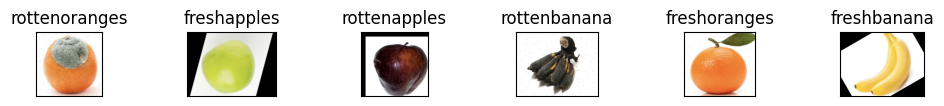

In [ ]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10,1),
                        subplot_kw={'xticks': [], 'yticks': []})
print(axes.flat)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
)

test_generator = ImageDataGenerator(
    validation_split = 0.8,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    subset="training"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    subset='validation'
)

val_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    subset="training"
)

Found 10901 validated image filenames belonging to 6 classes.
Found 2158 validated image filenames belonging to 6 classes.
Found 540 validated image filenames belonging to 6 classes.


In [ ]:
pretrained_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)
# pretrained_model.trainable = False
for layer in pretrained_model.layers[:-3]:
    layer.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
print(pretrained_model.layers[-3].name)

Conv_1


In [ ]:
tf.test.gpu_device_name()
inputs = pretrained_model.input
x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 128,
    epochs=2,
    steps_per_epoch=train_images.n//train_images.batch_size,
    validation_steps=val_images.n//val_images.batch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/2
85/85 [==============================] - 65s 762ms/step - loss: 0.0313 - accuracy: 0.9887 - val_loss: 0.0597 - val_accuracy: 0.9766
Epoch 2/2
85/85 [==============================] - 65s 764ms/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.0262 - val_accuracy: 0.9922


# Save model

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Final MobileNetV2/MB_V2[224x224][3].h5')

# Load trained model

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Final MobileNetV2/MB_V2[224x224][3].h5')

In [ ]:
# model.summary()

In [ ]:
def output(location,label=None):
    S = ''
    img=load_img(location,target_size=(224,224,3))
    # fig = plt.figure(figsize=(3,3))
    image = img
    img=img_to_array(img)
    img=img/255
    plt.imshow(img)
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    S = S + 'Predicted label: ' + res
    S = S + '\nTrue label: ' + label
    plt.title(S)
    return

#Predict on test data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]

17/17 [==============================] - 15s 776ms/step


#Save and load predicted label on test data

In [ ]:
# with open('/content/drive/My Drive/Colab Notebooks/dataset-fruits-fresh-and-rotten/label_prediction_mbv2_2.txt','w') as f:
#     f.writelines([f"{line}\n" for line in pred1])

In [ ]:
# with open('/content/drive/My Drive/Colab Notebooks/dataset-fruits-fresh-and-rotten/label_prediction_mbv2_2.txt') as f:
#   prediction = f.read().splitlines()

In [ ]:
results = model.evaluate(test_images,batch_size=32)
print(results)

17/17 [==============================] - 13s 719ms/step - loss: 0.0134 - accuracy: 0.9940
[0.013446971774101257, 0.9939758777618408]


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'freshapples',
 1: 'freshbanana',
 2: 'freshoranges',
 3: 'rottenapples',
 4: 'rottenbanana',
 5: 'rottenoranges'}

#Display and predict some images

In [ ]:
test_path = "/content/fruits-fresh-and-rotten-for-classification/dataset/test/"
for class_name in os.listdir(test_path):
  T = os.listdir(test_path + '/' + class_name)[:3]
  fig = plt.figure(figsize=(25,25),dpi = 100)
  for x in range(len(T)):
    fig.add_subplot(6,3,x+1)
    output(test_path + class_name + '/' + T[x],class_name)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Display confusion matrix

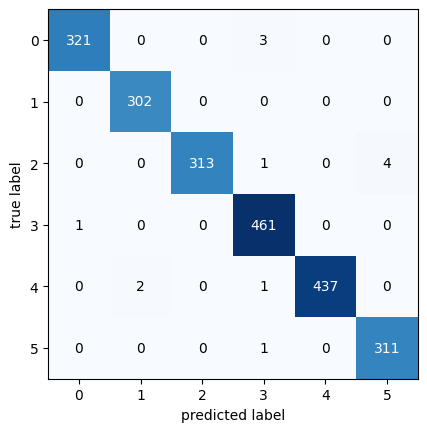

In [ ]:
y_true = [labels[x] for x in test_images.classes]
mat = confusion_matrix(y_true, pred1)
fig, ax = plot_confusion_matrix(mat)
plt.show()

In [ ]:
print(classification_report(y_true,pred1))

               precision    recall  f1-score   support

  freshapples       1.00      0.99      0.99       324
  freshbanana       0.99      1.00      1.00       302
 freshoranges       1.00      0.98      0.99       318
 rottenapples       0.99      1.00      0.99       462
 rottenbanana       1.00      0.99      1.00       440
rottenoranges       0.99      1.00      0.99       312

     accuracy                           0.99      2158
    macro avg       0.99      0.99      0.99      2158
 weighted avg       0.99      0.99      0.99      2158



#Accuracy on test data

In [ ]:
accuracy_score(y_true,pred1)

0.9939759036144579